### A) summarize the main results in the paper;

### B) Reproduce the results in Figure 1 in paper

### C) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). 

In [3]:
import numpy as np
import random
import numpy
from matplotlib import pyplot
import matplotlib.pyplot as plt


np.random.seed(1)

In [4]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

import matplotlib.pyplot as plt

def plot_bandits(results):
    fig, ax = plt.subplots()
    plt.style.use('seaborn-whitegrid')
    time_steps = len(np.array(results).T[0])
    plt.plot(np.arange(0, time_steps), [ts[0] for ts in results[:time_steps]], color="blue" )
    plt.plot(np.arange(0, time_steps), [ts[1] for ts in results[:time_steps]], color="green" )
    plt.plot(np.arange(0, time_steps), [ts[2] for ts in results[:time_steps]], color="red" )
    plt.plot(np.arange(0, time_steps), [ts[3] for ts in results[:time_steps]], color="teal" )
    plt.plot(np.arange(0, time_steps), [ts[4] for ts in results[:time_steps]], color="magenta")
    plt.plot(np.arange(0, time_steps), [ts[5] for ts in results[:time_steps]], color="yellow" )
    plt.show()


In [52]:
class NormalBandit:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def reward(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]

In [117]:
class BanditTrials:
    
    def __init__(self, bandits, n_trials=10, n_time_steps=100):
        self.n_trials = n_trials
        self.n_time_steps = n_time_steps
        self.total_trial_results = []
        self.bandits = bandits
        
    def run_action_elimination_trials(self):
        self.run_trials(ActionEliminationBanditTrial)

    def run_ucb_trials(self):
        self.run_trials(UCBBanditTrial)

        
    def run_trials(self, strategy):
        self.total_trial_results = []
        h1 = self.H1([b.mu for b in self.bandits])
        for trial_num in np.arange(0, self.n_trials):
            trial = strategy(self.bandits)
            trial.run_trial(time_steps=self.n_time_steps)
            self.total_trial_results.append(trial.pull_count_per_timestep / h1)
            print("Trial {} of {} complete".format(trial_num + 1, self.n_trials), end='\r')

            
    
    def H1(self, true_means):
        """ Hardness of the Trial"""
        optimal_mean = np.max(true_means)        
        delta = optimal_mean - true_means
        return np.sum(np.power(delta[1:], -2))

    def results_as_probability(self):
        return [softmax(result) for result in np.mean(self.total_trial_results, axis=0)]


In [69]:
class ActionEliminationBanditTrial:
    def __init__(self, bandits):
        """
        bandit_means
            a list of means that will be used to build the bandits
        r_k = 1
            is the number of samples per epoch for each arm. 
        """
        self.bandits = bandits 
        
        self.bandit_count = len(self.bandits)
        self.k = self.bandit_count
        
        bandit_means = [b.mu for b in bandits ]
        self.optimal_bandit = np.argmax(bandit_means)
        self.rewards_per_arm = [[] for _x in np.arange(0, self.bandit_count)]
        self.estimated_action_reward = np.zeros(self.bandit_count)

        self.delta = 0.1       
        self.active_bandits = np.ones(self.bandit_count)

        self.pull_count_per_timestep = []

    def empirical_mean(self, bandit_index):
        r"""
        Calculate the empirical mean of a given bandit (indexed). When an arm is hasn't been pulled, return -Infinity
        """
        if len(self.rewards_per_arm[bandit_index]) == 0:
            return -np.Inf
        return np.mean(self.rewards_per_arm[bandit_index])
    
    def active_bandit_indexes(self):
        r"""
        self.active_bandits is |n|. Return only the indexes == 1.
        """
        return np.nonzero(self.active_bandits)[0]
    
    def estimated_best_bandit_mean(self):
        """ returns a tuple with the best bandit index and the empirical mean"""
        all_empirical_means = [self.empirical_mean(idx) for idx,rewards in enumerate(self.bandits)]
        best_arm_index = np.nanargmax(all_empirical_means)
        return (best_arm_index, all_empirical_means[best_arm_index])

    def arm(self, idx):
        return self.bandits[idx]

    def pull_arm(self, idx):
        return self.arm(idx).reward()
    
    def drop_arm(self, idx):
        self.active_bandits[idx] = 0
        
    def C_ik(self, bandit_index):
        k = len(self.rewards_per_arm[bandit_index])
        n = self.bandit_count        
        if k == 0:
            return 0

        A = np.power(np.pi , 2 ) / 3
        B = n * np.power(k, 2) / self.delta   
        
        return np.sqrt( np.log( A * B) / k  )
    
    def stopping_condition_reached(self):
        return len(self.active_bandit_indexes()) == 1
            
    def run_trial(self, time_steps=500):
        current_epoch = 0
        for step in np.arange(0,time_steps):
            # Stopping Condition
            if self.stopping_condition_reached():
                mean = self.estimated_best_bandit_mean()
                print("Stopping. Best Arm: {}. Found in {} time steps".format(mean[0], step))
                print("Estimated mean: {}. ".format(mean[1]))
                print("Empirical mean: {}. ".format(self.arm(self.optimal_bandit).mu))
                break
            
            bandit_index = np.random.choice(self.active_bandit_indexes())
            self.rewards_per_arm[bandit_index].append(self.pull_arm(bandit_index))
            
            reference_arm = self.estimated_best_bandit_mean()
            reference_C_t = self.C_ik(reference_arm[0])

            for bandit_idx in self.active_bandit_indexes():
                candidate_arm_mean = self.empirical_mean(bandit_idx)
                candidate_C_t = self.C_ik(bandit_idx)
                lhs = reference_arm[1] - reference_C_t
                rhs = candidate_arm_mean + candidate_C_t
                if lhs >= rhs and rhs > (-np.inf):
#                    print("Dropping:  {}: {} < {}".format(bandit_idx, lhs, rhs ))
                    self.drop_arm(bandit_idx)

            # calculate P(I_t = i)
            if current_epoch > 0:
                self.pull_count_per_timestep.append([len(self.rewards_per_arm[idx]) for idx, _b in enumerate(self.bandits)])
            if step > 0 and step % (self.k - 1) == 0:
                current_epoch += 1

In [105]:
class UCBBanditTrial:
    def __init__(self, bandits):
        """
        bandit_means
            a list of means that will be used to build the bandits
        """
        self.bandits = bandits 
        
        self.bandit_count = len(self.bandits)
        
        bandit_means = [b.mu for b in bandits ]
        self.optimal_bandit = np.argmax(bandit_means)
        self.rewards_per_arm = [[] for _x in np.arange(0, self.bandit_count)]
        self.estimated_action_reward = np.zeros(self.bandit_count)

        self.delta = 0.1       
        self.pull_count_per_timestep = []

    def arm(self, idx):
        return self.bandits[idx]

    def pull_arm(self, idx):
        return self.arm(idx).reward()
    
    def empirical_mean(self, bandit_index):
        r"""
        Calculate the empirical mean of a given bandit (indexed). When an arm is hasn't been pulled, return -Infinity
        """
        if len(self.rewards_per_arm[bandit_index]) == 0:
            return -np.Inf
        return np.mean(self.rewards_per_arm[bandit_index])
    
    def all_empirical_means(self):
        return [self.empirical_mean(idx) for idx,rewards in enumerate(self.bandits)]
    
    def estimated_best_bandit_mean(self):
        """ returns a tuple with the best bandit index and the empirical mean"""
        means = self.all_empirical_means()
        best_arm_index = np.nanargmax(means)
        return (best_arm_index, means[best_arm_index])

        
    def C_ik(self, bandit_index):
        k = len(self.rewards_per_arm[bandit_index])
        n = self.bandit_count        
        if k == 0:
            return 0

        A = np.power(np.pi , 2 ) / 3
        B = n * np.power(k, 2) / self.delta   
        return np.sqrt( np.log( A * B) / k  )
    
    def stopping_condition_reached(self):
        return False
    
    def print_stopping_condition(self, step):
        mean = self.estimated_best_bandit_mean()
        print("Stopping. Best Arm: {}. Found in {} time steps".format(mean[0], step))
        print("Estimated mean: {}. ".format(mean[1]))
        print("Empirical mean: {}. ".format(self.arm(self.optimal_bandit).mu))
        
    def run_trial(self, time_steps=500):
        for step in np.arange(0,time_steps):
            # Stopping Condition
            if self.stopping_condition_reached():
                self.print_stopping_condition(step)
                break

            # check to see if we haven't sampled a bandit yet:
            unexplored = np.where(np.isinf(self.all_empirical_means()))[0]
            if len(unexplored) != 0:
                # grab the next one:
                bandit_index = unexplored[0]
            else:
                results = [mean + self.C_ik(idx) for idx,mean in enumerate(self.all_empirical_means())]
                bandit_index = np.argmax(results)

            self.rewards_per_arm[bandit_index].append(self.pull_arm(bandit_index))
            
            reference_arm = self.estimated_best_bandit_mean()
            reference_C_t = self.C_ik(reference_arm[0])

            for bandit_idx,_b in enumerate(self.bandits):
                candidate_arm_mean = self.empirical_mean(bandit_idx)
                candidate_C_t = self.C_ik(bandit_idx)
                lhs = reference_arm[1] - reference_C_t
                # TODO second best arm:
                rhs = candidate_arm_mean + candidate_C_t

            self.pull_count_per_timestep.append([len(self.rewards_per_arm[idx]) for idx, _b in enumerate(self.bandits)])

            
BANDIT_MEANS = [ 1, 4/5, 3/5, 2/5, 1/5, 0]
SIGMA = 1/4

#trial = UCBBanditTrial([NormalBandit(mean, SIGMA) for mean in BANDIT_MEANS])
#trial.run_trial()

array([2])

In [61]:
BANDIT_MEANS = [ 1, 4/5, 3/5, 2/5, 1/5, 0]
SIGMA = 1/4

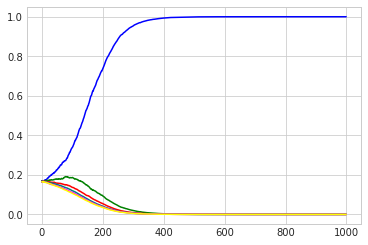

In [119]:
bandits = [NormalBandit(mean, SIGMA) for mean in BANDIT_MEANS]
trials = BanditTrials(bandits, n_trials=5, n_time_steps=1000)
trials.run_ucb_trials()
results = trials.results_as_probability()
plot_bandits(results)

### D) discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification